In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [ ]:
# 압축풀기
import zipfile 
with zipfile.ZipFile('/kaggle/input/caterpillar-tube-pricing/data.zip','r') as z:
    z.extractall('data')

In [ ]:
train = pd.read_csv('data/competition_data/train_set.csv')
train.head(10)
test = pd.read_csv('data/competition_data/test_set.csv')
test.head(10)
display(train.shape, test.shape)

In [ ]:
train.head(10)

In [ ]:
bill = pd.read_csv('data/competition_data/bill_of_materials.csv')
bill.head()
bill.shape

In [ ]:
alldata = pd.concat([train, test])
alldata.shape

In [ ]:
# tube 데이터셋 홈피가 중요하다고 해서 추가 준비/ 확인
tube = pd.read_csv('data/competition_data/tube.csv')
tube.head(10)

# 이전 id는 여러값이 중복으로나와 대표값으로 해야했는데 
alldata = pd.merge(alldata, tube, on='tube_assembly_id', how='left')

In [ ]:
# 날짜 변수를 추가해 가장 쉽게 점수올리기 
alldata['quote_date'] = alldata['quote_date'].astype('datetime64')
alldata['year'] = alldata['quote_date'].dt.year
alldata.groupby('year')['cost'].mean() # 연도에 따라서 크게크게 편차가 있기떄문에 도움이됨 #1985년이 nan인데, test셋에만 있는 연도라 nan으로 찍힘. train셋에는 1985가 없음

alldata['month'] = alldata['quote_date'].dt.month
alldata['day'] = alldata['quote_date'].dt.day
alldata.head()

# 날짜 변수 추가하면 70정도 오름

In [ ]:
pd.options.display.max_columns = 100
alldata.head()

# 교호작용 feature / material id 로 추가 변수 생성
# 교호작용
alldata['numcomponents'] = alldata['num_boss'] + alldata['num_bracket'] + alldata['other'] + alldata['num_bends']


In [ ]:
alldata['numcomponents']

In [ ]:
material_length=alldata.groupby('material_id')['length'].agg(['mean','min','std','count','max']).reset_index()
material_length

In [ ]:
# alldata.groupby('tube_assembly_id')['quantity'].mean().head(50) # id 별로 즉 상품 별로, 뭉태기, 덩어리 하나로만 파는지 정보가 추가됨 
# id_quantity = alldata.groupby('tube_assembly_id')['quantity'].mean().reset_index() # id 별로 즉 상품 별로, 뭉태기, 덩어리 하나로만 파는지 정보가 추가됨 

In [ ]:
# train.head(10)
# # 문자와 숫자형 컬럼을 합치면 새로운 변수 탄생 가능 (tube_assembly_id만 가지고도 여러 정보 얻을 수 있음 )
# train['tube_assembly_id'].value_counts() # TA-04788 제품이 14개가 되니 새로운 데이터를 14개 만들수 잇음 -> 각각 id별로 등장한 횟수 파악

# # alldata.groupby('tube_assembly_id')['quantity'].count().reset_index().head(50) # id별로 각각 몇개씩 팔리는지 확인가능 #이게 중요한 것임, 여기서 차별점을 만들어냄, 기존 변수 활용이 아닌 새로운 변수를 만들어냄
# id_count= alldata.groupby('tube_assembly_id')['quantity'].count().reset_index()

In [ ]:
supplier_count = alldata.groupby('supplier')['quantity'].count().reset_index()
# supplier_count 이름 바꾸는법 
supplier_count = alldata.groupby('supplier')['quantity'].count().reset_index().rename({'quantity':'supplier_counts'}, axis=1)
supplier_count

In [ ]:
train.head()

In [ ]:
supplier_annual_usage = alldata.groupby('supplier')['annual_usage'].agg(['count','mean','max','std']).reset_index()
# 각 공급자 마다 어떤 건 많이, 어떤 제품은 낮게 사용하면 std가 큼. 이 내용도 추가

In [ ]:
alldata.groupby('tube_assembly_id')['quantity'].agg(['count','mean','max']).reset_index() # 대표값들을 변수로 생성



# material_id 들도 가능함 

In [ ]:
alldata = pd.merge(alldata, bill, on='tube_assembly_id', how='left')
id_count= alldata.groupby('tube_assembly_id')['quantity'].agg(['count','mean','max']).reset_index() # agg를 쓰면 count랑 mean도 했는데 이를 한번에 해버리겠따(=여러 함수 동시에 적용하겠다 )

# id_count= alldata.groupby('tube_assembly_id')['quantity'].count().reset_index()
alldata = pd.merge(alldata, id_count, on='tube_assembly_id', how='left')
alldata = pd.merge(alldata, supplier_annual_usage, on='supplier', how='left')
# alldata = pd.merge(alldata, id_quantity, on='tube_assembly_id', how='left')
alldata = pd.merge(alldata, material_length, on='material_id', how='left')


In [ ]:
# 22:46 튜브 데이터 추가후, 문자를 숫자로 변경 
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
for i in alldata.columns[alldata.dtypes==object]:
    alldata[i] = le.fit_transform(list(alldata[i]))
# '<' not supported between instances of 'str' and 'float' -> 결측치가 있다는 것임 alldata[i] -> list(alldata[i])로 묶어줌 
# list로 묶어 주면 문자로 인식해서 접근 가능 

In [ ]:
alldata= alldata.fillna(-1)

In [ ]:
alldata2 = alldata.drop(['cost','id','quote_date'],axis=1)
train2 = alldata2[:len(train)]
test2 = alldata2[len(train):]

In [ ]:
train['cost']

In [ ]:
# 그림 - 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20, 12))
sns.distplot(train['cost'])

In [ ]:
target = train['cost']
target_log = np.log(target)

In [ ]:
# 그림 - 
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize = (20, 12))
sns.distplot(target_log)

In [ ]:
target_log

In [ ]:
alldata

In [ ]:
# 모델 선택 - 머신러닝 대회에서는 무조건 랜포를 먼저 사용 
# 데이터셋이 단순한지 복잡한지 파악이 안되었기때문에 랜포를 써서 판단

# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=4)
# rf.fit(train2, train['cost'])
# result = rf.predict(test2)


# from sklearn.ensemble import RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=4)
# rf.fit(train2, target_log)
# result = rf.predict(test2)
# result = np.exp(result)

# from lightgbm import LGBMRegressor
# lgb= LGBMRegressor(num_leaves = 80, colsample_bytree =  0.8, subsample = 0.6  ) # num_leaves(=노드임, 기본값 31 / colsample_bytree(0.8이면 80개씩 랜덤하게 뽑겠다) / cat_boost?(카테고리형 변수를 처리를 잘하도록 만들어진 알고리즘) 이 세가지는 머신러닝에서 필수 옵션
# xg 부스트는 맥스 뎁스 밖에 없음
# lgbm에서 max depth를 설정하면 num leaves를 설정하는 이유가 없어짐 
# depth 6이면 num leaves 는 64개 

# cat_boost를 쓰는 이유는 따로 옵션을 설정해주지 않아도 자기가 알아서 데이터의 복잡도를 학습할 수 있음 / 카테고리형 변수를 처리를 잘하도록 만들어진 알고리즘
# lgbm 보다 더 좋은 결과 가져옴 옵션을 설정하지 않아도 
# from catboost import CatBoostRegressor
# cbr = CatBoostRegressor()
# cbr.fit(train2, target_log)
# result = cbr.predict(test2)
# result = np.exp(result)


# quantity를 계속 추가하다 보니 quantity_x, quantity_y로 계속 생성중 -> np array로 묶으면 변수명 신경 x
# from catboost import CatBoostRegressor
# cbr = CatBoostRegressor()
# cbr.fit(np.array(train2), target_log)
# result = cbr.predict(np.array(test2))
# result = np.exp(result)



# lgbm 으로 성능 더 내기 23:34
from lightgbm import LGBMRegressor
lgb= LGBMRegressor(num_leaves = 80, colsample_bytree =  0.8, subsample = 0.6, n_estimators=3500, learning_rate=0.02) 
# 왠만하면 700으로 설정함, learning rate를 설정해줘서 / learning를 0.1 -> 0.02 로 느리게 해놓아서 이에 맞춰 반비례 관계로 나무의 갯수를 늘려줘야함 / learning rate를 느리게 해주면 수렴할 수 있게끔 나무의 갯수를 늘려줘야함 
# 이 하이퍼파라미터에 맞게 얼마나 많은 나무를 만들어야하는지 n_estimators
# lgbm에서 max depth를 설정하면 num leaves를 설정하는 이유가 없어짐 
# depth 6이면 num leaves 는 64개 

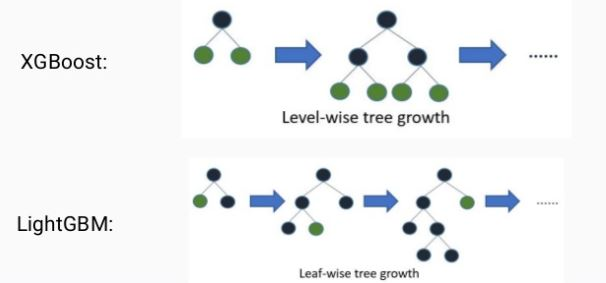

lgb 은 한층을 완성하는게 아니라 질문을 세분화하는데 초점을 둠 

In [ ]:
lgb.fit(train2, target_log)
result = lgb.predict(test2)
result = np.exp(result)

# 완전 기본 lgb를 돌리면 점수 안좋아지겠구나
# 근데 이건 lgb가 더 좋은 값이 나옴 -> 이 데이터셋은 lgbm이 잘 적용되구나

# 데이터 복잡도는 
# 1. 행/열 갯수로 파악 1000~10000개면 중간정도 복잡도 depth 6~7이 최적.  lgb은 leaves로 적용되서 64~128
# calsample / num_leaves(하나의 나무가 만들어질떄 잎사귀 갯수) = 31이 기본 75 최적 

In [ ]:
sub = pd.read_csv('/kaggle/input/caterpillar-tube-pricing/sample_submission.csv')
sub['cost'] = result
sub.head()

In [ ]:
sub.to_csv('class.csv', index = False)

In [ ]:
# y값 안정되지 않은 상황에서 부스팅 모델로 바꿔버리면 그 특정 데이터를 집중적으로 학습하는 경향이 있어 
# 도움이 되는 옵션(칼럼)인 경우에도 불구하고 결과 안좋아짐